# Enunciado

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Algunos frameworks/librerías que traen modelos e interfaces preparadas para armar rápidamente un sistema basado en NLP:

- DeepPavLov
- Hugging Face
- FastAI
- ParlAI

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

# 1. Datos

## Importaciones

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import os
import pickle
import timeit

## Defino parametros recomendadas para el modelo

## Dataset

In [2]:
# Instalar la librería si no la tienes
!pip install datasets

from datasets import load_dataset

# Descargar el dataset wiki_qa
dataset = load_dataset("wiki_qa", split="train")


In [3]:
# Convertir a pandas DataFrame para facilitar el manejo
import pandas as pd

df = pd.DataFrame(dataset)  # El split por defecto es 'train'

# Extraer listas de preguntas y respuestas
questions = df['question'].tolist()
answers = df['answer'].tolist()# Agrega tokens explícitos como <start> y <end> en las respuestas antes de la tokenización:
answers = ["<start> " + answer + " <end>" for answer in answers]

# Asegura que solo haya un <start> y un <end> por respuesta
def add_special_tokens(text):
    text = text.strip()
    text = text.replace('<start>', '').replace('<end>', '').strip()
    return f"<start> {text} <end>"

answers = [add_special_tokens(a) for a in answers]

# Calcular las longitudes de las preguntas
lengths_questions = [len(q.split()) for q in questions]
# Calcular el percentil 95 para cada tipo de secuencia
max_length_questions = int(np.percentile(lengths_questions, 95))
lengths_answers = [len(a.split()) for a in answers]
max_length_answers = int(np.percentile(lengths_answers, 95))

In [4]:
MAX_VOCAB_SIZE = 8000 #baje desde 5000 para mejorar la precisión
#MAX_LENGTH = 12  # definida arriba con el percentil 95
EMBEDDING_DIM = 300  # FastText
N_UNITS = 128
LSTM_DROPOUT = 0.2
EPOCHS = 40  # Promedio recomendado

# Preprocesamiento

## Tokenización de preguntas y respuestas


In [5]:
#Vocabulario de entrada: 4083 palabras
#Vocabulario de salida: 32275 palabras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Tokenizador para preguntas (inputs)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(questions)
input_integer_seq = input_tokenizer.texts_to_sequences(questions)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario (input):", len(word2idx_inputs))

max_input_len = max(len(seq) for seq in input_integer_seq)
print("Pregunta más larga:", max_input_len)

# Tokenizador para respuestas (outputs)
#output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!\"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, 
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',  # Quita '<' y '>' de los filtros
    oov_token='<unk>'  # Opcional: token para palabras desconocidas
)

output_tokenizer.fit_on_texts(answers)
output_integer_seq = output_tokenizer.texts_to_sequences(answers)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario (output):", len(word2idx_outputs))

max_output_len = max(len(seq) for seq in output_integer_seq)
print("Respuesta más larga:", max_output_len)

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)  # +1 para el token de palabra desconocida


Palabras en el vocabulario (input): 4082
Pregunta más larga: 23
Palabras en el vocabulario (output): 32274
Respuesta más larga: 167


## Padding de secuencias


In [6]:
# Limitar longitudes si es necesario
max_input_len = min(max_input_len, max_length_questions)
max_output_len = min(max_output_len, max_length_answers)

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')

print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)


encoder_input_sequences shape: (20360, 12)
decoder_input_sequences shape: (20360, 46)


## One-hot encoding de las salidas

In [7]:
from tensorflow.keras.utils import to_categorical

decoder_targets = to_categorical(decoder_input_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)


decoder_targets shape: (20360, 46, 8000)


## Descargar Fasttext

In [8]:
import os

if not os.path.exists("cc.en.300.vec"):
    if not os.path.exists("cc.en.300.vec.gz"):
        # Descargar solo si el archivo comprimido no existe
        !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
    # Descomprimir solo si el archivo descomprimido no existe
    !gunzip cc.en.300.vec.gz
else:
    print("El archivo cc.en.300.vec ya existe, no se descarga ni descomprime.")

El archivo cc.en.300.vec ya existe, no se descarga ni descomprime.


# Preparear los embeddings

## Descargar y Descomprimir los Embeddings FastText

In [9]:
EMBEDDING_VEC_TXT = 'cc.en.300.vec'
EMBEDDING_VEC_PKL = 'cc.en.300.vec.pkl'

if os.path.exists(EMBEDDING_VEC_PKL):
    print("Cargando embeddings desde el archivo pickle...")
    with open(EMBEDDING_VEC_PKL, 'rb') as f:
        embedding_index = pickle.load(f)
else:
    print("Procesando archivo de texto de embeddings...")
    embedding_index = {}
    with open(EMBEDDING_VEC_TXT, encoding='utf-8', errors='ignore') as f:
        next(f)  # saltea la primera línea si tiene info de vocabulario
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
    # Guardar para la próxima vez
    with open(EMBEDDING_VEC_PKL, 'wb') as f:
        pickle.dump(embedding_index, f)
    print("Embeddings guardados en archivo pickle.")

print(f"Cantidad de palabras en embeddings: {len(embedding_index)}")

Cargando embeddings desde el archivo pickle...
Cantidad de palabras en embeddings: 2000000


## Crear la Embedding Matrix para el Encoder

In [10]:
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    # Si la palabra no está, la fila queda en ceros (vector nulo)


## Verificar la Embedding Matrix


In [11]:
print('embedding_matrix shape:', embedding_matrix.shape)
print('Número de palabras sin embedding:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

embedding_matrix shape: (4083, 300)
Número de palabras sin embedding: 155


## Definición del Modelo Seq2Seq (Encoder-Decoder)


In [12]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model

# Encoder
encoder_inputs = Input(shape=(max_input_len,), name='encoder_input') # Add name
encoder_embedding = Embedding(
    input_dim=nb_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False,
    name='encoder_embedding' # Add name
)(encoder_inputs)
encoder_lstm = LSTM(N_UNITS, return_state=True, dropout=LSTM_DROPOUT, name='encoder_lstm') # Add name
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_output_len,), name='decoder_input') # Add name
decoder_embedding = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
    name='decoder_embedding' # Add name
)(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(N_UNITS, return_sequences=True, return_state=True, dropout=LSTM_DROPOUT, name='decoder_lstm') # Add name
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax', name='decoder_dense') # Add name
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, 12, 300)   │  1,224,900 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, 46, 128)   │  1,024,000 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    219,648 │ encoder_embeddin… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 46, 128), │    131,584 │ decoder_embeddin… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 46, 8000)  │  1,032,000 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,632,132 (13.86 MB)

 Trainable params: 2,407,232 (9.18 MB)

 Non-trainable params: 1,224,900 (4.67 MB)

# Entrenamiento del modelo

In [13]:
## Entrenamos y guardamos el modelo

In [14]:
# Entrenar el modelo
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    batch_size=512,
    epochs=EPOCHS,  # Puedes ajustar entre 30 y 50 según recursos y overfitting
    validation_split=0.2
)
model.save('my_model.keras')

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4358 - loss: 7.8084 - val_accuracy: 0.4811 - val_loss: 4.0062
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4799 - loss: 3.8496 - val_accuracy: 0.4811 - val_loss: 3.4441
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.4823 - loss: 3.3704 - val_accuracy: 0.5021 - val_loss: 3.1547
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5025 - loss: 3.1167 - val_accuracy: 0.5212 - val_loss: 3.0114
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5314 - loss: 2.9777 - val_accuracy: 0.5533 - val_loss: 2.9123
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5568 - loss: 2.8696 - val_accuracy: 0.6017 - val_loss: 2.7965
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6058 - loss: 2.7567 - val_accuracy: 0.6384 - val_loss: 2.6545
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6538 - loss: 2.6254 - val_accuracy: 0.6813 - val_loss:

## Visualización

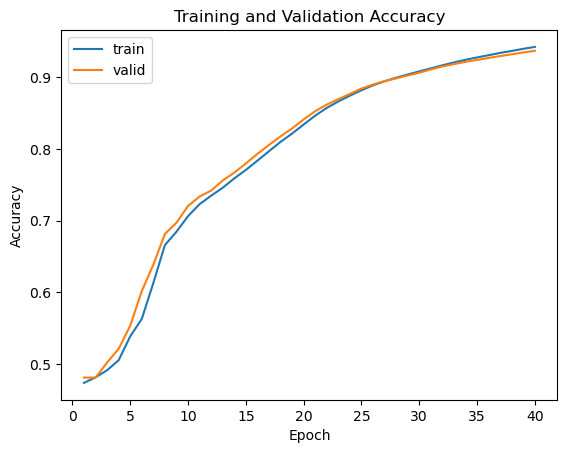

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# Prueba del modelo

## Defino el modelo del encoder y del decoder

In [20]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

# --- Encoder de inferencia ---
# We create new Input tensors for the inference model, but use the trained layers
encoder_inf_inputs = Input(shape=(max_input_len,), name='encoder_inf_input')

# Get the trained layers from the original model by name
encoder_embedding_layer_inf = model.get_layer('encoder_embedding')
encoder_lstm_layer_inf = model.get_layer('encoder_lstm')

# Connect the inference input through the trained encoder layers
encoder_embedding_output_inf = encoder_embedding_layer_inf(encoder_inf_inputs)
_, state_h_inf, state_c_inf = encoder_lstm_layer_inf(encoder_embedding_output_inf)
encoder_states_inf = [state_h_inf, state_c_inf]

# Define the encoder inference model
encoder_model = Model(encoder_inf_inputs, encoder_states_inf)

# --- Decoder de inferencia ---
# Inputs to the decoder inference model: [one token input, state_h from previous step, state_c from previous step]
decoder_state_input_h_inf = Input(shape=(N_UNITS,), name='decoder_state_input_h_inf')
decoder_state_input_c_inf = Input(shape=(N_UNITS,), name='decoder_state_input_c_inf')
decoder_states_inputs_inf = [decoder_state_input_h_inf, decoder_state_input_c_inf]

decoder_inputs_single_inf = Input(shape=(1,), name='decoder_input_single_inf') # Input shape is (batch_size, 1)

# Get the trained layers for the decoder by name
decoder_embedding_layer_inf = model.get_layer('decoder_embedding')
decoder_lstm_layer_inf = model.get_layer('decoder_lstm')
decoder_dense_layer_inf = model.get_layer('decoder_dense')

# Connect the inference inputs through the trained decoder layers
decoder_inputs_single_x_inf = decoder_embedding_layer_inf(decoder_inputs_single_inf) # Output shape (None, 1, N_UNITS)

# Note: decoder_lstm_layer_inf is the trained LSTM layer instance
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm_layer_inf(
    decoder_inputs_single_x_inf,
    initial_state=decoder_states_inputs_inf # Pass the states from the previous time step
)

# Pass the LSTM output through the trained dense layer
decoder_outputs_inf = decoder_dense_layer_inf(decoder_outputs_inf) # Output shape (None, 1, num_words_output)

# Define the decoder inference model
# Inputs: [single token input] + [previous state H, previous state C]
# Outputs: [predicted token distribution] + [next state H, next state C]
decoder_model = Model(
    [decoder_inputs_single_inf] + decoder_states_inputs_inf,
    [decoder_outputs_inf] + [state_h_inf, state_c_inf]
)

# Optional: Print summaries to verify they are built correctly
# encoder_model.summary()
# decoder_model.summary()

## Preparar los conversores de índices

In [21]:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_output = {v: k for k, v in word2idx_outputs.items()}

## Función de inferencia (QA Bot)

In [22]:
def answer_question(question_text):
    # Tokenizar y paddear la pregunta
    seq = input_tokenizer.texts_to_sequences([question_text])
    # Ensure seq is a list of lists, pad_sequences expects this format
    if not isinstance(seq, list):
        seq = [seq]
    seq = pad_sequences(seq, maxlen=max_input_len) # Shape (1, max_input_len)

    # Obtener los estados del encoder
    # This call to encoder_model.predict should now work with the correct input shape
    states_value = encoder_model.predict(seq, verbose=0) # Add verbose=0 to hide progress bar

    # Initialize sequence of input to the decoder. Start with the start token.
    target_seq = np.zeros((1, 1))
    start_token_id = word2idx_outputs.get('<start>', 0) # Get ID for <start>, default to 0 if not found
    if start_token_id == 0:
         print("Warning: '<start>' token not found in output vocabulary.")
         # Handle this case - maybe return an error or a default response
         return "Error: Decoder start token not found."
    target_seq[0, 0] = start_token_id

    # Get the end token ID
    end_token_id = word2idx_outputs.get('<end>', -1) # Get ID for <end>, default to -1 (unlikely index)

    output_sentence = []
    # Max length for generated sequence to prevent infinite loops
    for _ in range(max_output_len):
        # Predict next token and get the next states
        # Pass the single token input and the states from the previous step
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get the predicted token index. The output is (batch_size, 1, vocab_size)
        # We need the probabilities for the single time step (index 0)
        sampled_token_index = np.argmax(output_tokens[0, 0, :])

        # Look up the word
        sampled_word = idx2word_output.get(sampled_token_index, '<unk>') # Default to <unk>

        # Check if it's the end token or max length reached
        if sampled_token_index == end_token_id:
            break

        # Avoid adding the start token, padding, or unknown tokens to the output string
        if sampled_word not in ['<start>', '<end>', '<pad>', '<unk>']:
             output_sentence.append(sampled_word)
        # Optionally, you might want to include <unk> if it's important

        # Update states for the next time step
        states_value = [h, c]

        # Update target sequence (input for the next time step is the token we just predicted)
        target_seq = np.zeros((1, 1)) # Create a new input sequence (shape (1, 1))
        target_seq[0, 0] = sampled_token_index # Set the input to the predicted token index

    # Join the collected words into a sentence
    return ' '.join(output_sentence)

In [26]:
def answer_question(question_text):
   # Tokenizar y paddear la pregunta
    seq = input_tokenizer.texts_to_sequences([question_text])
    # Ensure seq is a list of lists, pad_sequences expects this format
    if not isinstance(seq, list):
        seq = [seq]
    seq = pad_sequences(seq, maxlen=max_input_len) # Shape (1, max_input_len)

    # Obtener los estados del encoder
    # This call to encoder_model.predict should now work with the correct input shape
    states_value = encoder_model.predict(seq, verbose=0) # Add verbose=0 to hide progress bar

    # Initialize sequence of input to the decoder. Start with the start token.
    target_seq = np.zeros((1, 1))
    start_token_id = word2idx_outputs.get('<start>', 0) # Get ID for <start>, default to 0 if not found
    if start_token_id == 0:
         print("Warning: '<start>' token not found in output vocabulary.")
         # Handle this case - maybe return an error or a default response
         return "Error: Decoder start token not found."
    target_seq[0, 0] = start_token_id

    # Get the end token ID
    end_token_id = word2idx_outputs.get('<end>', -1) # Get ID for <end>, default to -1 (unlikely index)

    output_sentence = []
    # Max length for generated sequence to prevent infinite loops
    for i in range(max_output_len): # Added index 'i' for debugging step number
        # Predict next token and get the next states
        # Pass the single token input and the states from the previous step
        print(f"Step {i+1}: Decoding with input token {target_seq[0,0]} (word: {idx2word_output.get(target_seq[0,0], 'N/A')})") # Debug print
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Get the predicted token index. The output is (batch_size, 1, vocab_size)
        # We need the probabilities for the single time step (index 0)
        sampled_token_index = np.argmax(output_tokens[0, 0, :])
        print(f"Step {i+1}: Predicted token index: {sampled_token_index}") # Debug print

        # Look up the word
        sampled_word = idx2word_output.get(sampled_token_index, '<unk>') # Default to <unk>
        print(f"Step {i+1}: Predicted word: {sampled_word}") # Debug print

        # Check if it's the end token or max length reached
        if sampled_token_index == end_token_id:
            print(f"Step {i+1}: Predicted <end> token. Breaking loop.") # Debug print
            break

        # Avoid adding the start token, padding, or unknown tokens to the output string
        if sampled_word not in ['<start>', '<end>', '<pad>', '<unk>']:
             output_sentence.append(sampled_word)

        # Update states for the next time step
        states_value = [h, c]

        # Update target sequence (input for the next time step is the token we just predicted)
        target_seq = np.zeros((1, 1)) # Create a new input sequence (shape (1, 1))
        target_seq[0, 0] = sampled_token_index # Set the input to the predicted token index

    # Join the collected words into a sentence
    return ' '.join(output_sentence)

## Probar las preguntas

In [27]:
test_questions = [
    "How can I reset my password?",
    "What payment methods do you accept?",
    "How do I update my account information?",
    "What is your privacy policy?",
    "Can I return a product if it was purchased as a gift?"
]

for q in test_questions:
    print("Q:", q)
    print("A:", answer_question(q))
    print("-" * 30)


Q: How can I reset my password?
Step 1: Decoding with input token 3.0 (word: <start>)
Step 1: Predicted token index: 3
Step 1: Predicted word: <start>
Step 2: Decoding with input token 3.0 (word: <start>)
Step 2: Predicted token index: 3
Step 2: Predicted word: <start>
Step 3: Decoding with input token 3.0 (word: <start>)
Step 3: Predicted token index: 3
Step 3: Predicted word: <start>
Step 4: Decoding with input token 3.0 (word: <start>)
Step 4: Predicted token index: 3
Step 4: Predicted word: <start>
Step 5: Decoding with input token 3.0 (word: <start>)
Step 5: Predicted token index: 0
Step 5: Predicted word: <unk>
Step 6: Decoding with input token 0.0 (word: N/A)
Step 6: Predicted token index: 0
Step 6: Predicted word: <unk>
Step 7: Decoding with input token 0.0 (word: N/A)
Step 7: Predicted token index: 0
Step 7: Predicted word: <unk>
Step 8: Decoding with input token 0.0 (word: N/A)
Step 8: Predicted token index: 0
Step 8: Predicted word: <unk>
Step 9: Decoding with input token 0.